# 2.5 DC Resisitivy inversion

In [1]:
import pathlib
import pooch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import discretize
import simpeg
from simpeg.electromagnetics.static import resistivity as dc

import inversion_ideas as ii

## Load data

In [2]:
url = "https://github.com/simpeg/user-tutorials/raw/main/assets/05-dcr/inv_dcr_2d_files.tar.gz"

fnames = pooch.retrieve(url, known_hash=None, processor=pooch.Untar())
fnames = [pathlib.Path(f) for f in fnames]
fnames

[PosixPath('/home/santi/.cache/pooch/a567d6514bf50ed948b5d7b7e4125664-inv_dcr_2d_files.tar.gz.untar/inv_dcr_2d_files/topo_2d.txt'),
 PosixPath('/home/santi/.cache/pooch/a567d6514bf50ed948b5d7b7e4125664-inv_dcr_2d_files.tar.gz.untar/inv_dcr_2d_files/dc_data.obs')]

In [3]:
topo_fname, = [f for f in fnames if "topo_2d.txt" in f.name]
data_fname, = [f for f in fnames if "dc_data.obs" in f.name]
topo_fname, data_fname

(PosixPath('/home/santi/.cache/pooch/a567d6514bf50ed948b5d7b7e4125664-inv_dcr_2d_files.tar.gz.untar/inv_dcr_2d_files/topo_2d.txt'),
 PosixPath('/home/santi/.cache/pooch/a567d6514bf50ed948b5d7b7e4125664-inv_dcr_2d_files.tar.gz.untar/inv_dcr_2d_files/dc_data.obs'))

In [4]:
# Load 2D topography
topo_2d = np.loadtxt(str(topo_fname))

In [5]:
voltage_data = simpeg.utils.io_utils.read_dcip2d_ubc(data_fname, "volt", "general")

In [6]:
# Apply uncertainties to normalized voltage data
voltage_data.standard_deviation = 1e-7 + 0.05 * np.abs(voltage_data.dobs)

In [7]:
# Get apparent conductivities from volts and survey geometry
apparent_resistivities = simpeg.electromagnetics.static.utils.static_utils.apparent_resistivity_from_voltage(
    voltage_data.survey, voltage_data.dobs
)

## Create mesh

In [8]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = discretize.TreeMesh([hx, hz], x0="CN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, topo_2d[:, -1].max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = voltage_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

In [9]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = discretize.utils.active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

In [10]:
# Project electrodes to topography
voltage_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define simulation

In [11]:
# Map model parameters to all cells.
# We'll use log conductivities as model, so we need to pass an ExpMap
# to the simulation in order to convert log conductivities to conductivities.
log_conductivity_map = (
    simpeg.maps.InjectActiveCells(mesh, active_cells, 1e-8) 
    * simpeg.maps.ExpMap(nP=n_active)
)

In [12]:
# Get median apparent resistivity
median_resistivity = np.median(apparent_resistivities)
median_conductivity = 1 / median_resistivity  

# TODO: this is not the median conduct, right?
# Shall we do median_conductivity = np.median(1 / apparent_resistivities)?

# Create initial model (log conductivity)
initial_model = np.log(1 / median_resistivity) * np.ones(n_active)

In [13]:
solver = simpeg.utils.solver_utils.get_default_solver()
simulation_simpeg = dc.simulation_2d.Simulation2DNodal(
    mesh, 
    survey=voltage_data.survey,
    sigmaMap=log_conductivity_map,
    storeJ=True,
    solver=solver,
)

## Create inversion

Wrap the simulation into an object that can be used in the new framework

In [14]:
simulation = ii.wrap_simulation(simulation_simpeg, store_jacobian=True)

Extract data and uncertainties from data object and build the data misfit

In [15]:
data = voltage_data.dobs
uncertainties = voltage_data.standard_deviation

data_misfit = ii.DataMisfit(data, uncertainties, simulation)

Define regularization (smallness) with sensitivity weights

In [16]:
# Get volume and sensitivity weights
volumes = mesh.cell_volumes[active_cells]
sensitivity_weights = ii.utils.get_sensitivity_weights(
    simulation.jacobian(initial_model),
    data_weights=data_misfit.weights_matrix,
)

# Compute the sqrt of the weights, to avoid high dynamic range
# TODO: double check this!
sensitivity_weights = np.sqrt(sensitivity_weights)

weights_dict = {
    "volume": volumes,
    "sensitivity": sensitivity_weights,
}

# Use the initial model as our reference model
reference_model = initial_model.copy()

smallness = ii.TikhonovZero(
    n_params=simulation.n_params, 
    weights=weights_dict,
    reference_model=initial_model,
)

/home/santi/.miniforge3/envs/inversion_ideas/lib/python3.13/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:768: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/santi/.miniforge3/envs/inversion_ideas/lib/python3.13/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:795: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]
/home/santi/.miniforge3/envs/inversion_ideas/lib/python3.13/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


In [17]:
sensitivity_weights.min(), sensitivity_weights.max()

(np.float64(0.0005065877439181947), np.float64(1.0))

Build objective function

In [36]:
beta_0 = 1e0
regularization = beta_0 * smallness
phi = data_misfit + regularization
phi

φd(m) + 1.00 φs(m)

In [37]:
data_misfit(initial_model), smallness(initial_model)

(np.float64(44539.14649205478), np.float64(0.0))

Get preconditioner

In [38]:
preconditioner = ii.get_jacobi_preconditioner(phi, initial_model)
# preconditioner = ii.JacobiPreconditioner(phi)
preconditioner

<DIAgonal sparse array of dtype 'float64'
	with 7205 stored elements (1 diagonals) and shape (7205, 7205)>

In [39]:
# Use conjugate gradient to run a single step minimization
cg_minimizer = ii.ConjugateGradient()
inverted_model = cg_minimizer(phi, initial_model, preconditioner=preconditioner)

In [40]:
inverted_model

array([-4.5815167 , -4.5815167 , -4.5815167 , ..., -4.68687812,
       -4.58811058, -4.58828272], shape=(7205,))

In [41]:
inverted_model.min(), inverted_model.max()

(np.float64(-6.503123156641239), np.float64(-2.673612369710134))

In [24]:
data_misfit(inverted_model), smallness(inverted_model)

(np.float64(14945.654336349657), np.float64(9123.272923491297))

In [42]:
old_fval = phi(initial_model)
gfk=phi.gradient(initial_model)

In [43]:
from scipy.optimize import line_search

model_step = inverted_model - initial_model
ls_result = line_search(
    phi,
    phi.gradient,
    initial_model,
    model_step,
    gfk=gfk,
    old_fval=old_fval,
)
ls_result

(1.0,
 1,
 1,
 np.float64(24068.92725984095),
 np.float64(44539.14649205478),
 array([-5.73590934e-01, -4.80375090e-01, -9.97118197e-01, ...,
        -2.25315753e-04, -8.21238004e-04, -4.20107363e-02], shape=(7205,)))

In [44]:
phi(inverted_model)

np.float64(24068.92725984095)

In [45]:
phi.gradient(inverted_model)

array([-5.73590934e-01, -4.80375090e-01, -9.97118197e-01, ...,
       -2.25315753e-04, -8.21238004e-04, -4.20107363e-02], shape=(7205,))

In [26]:
inverted_conductivity = np.exp(inverted_model)

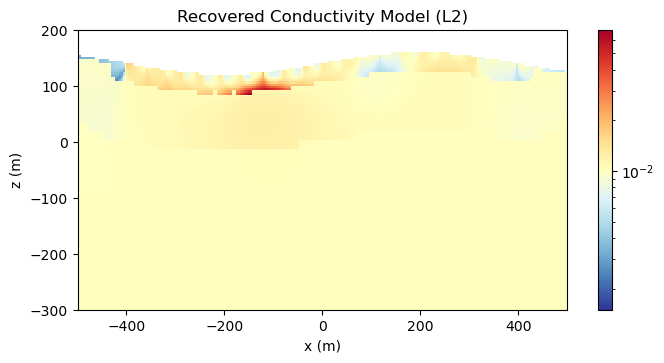

In [30]:
norm = LogNorm()
plotting_map = simpeg.maps.InjectActiveCells(mesh, active_cells, np.nan)

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
tmp, = mesh.plot_image(
    plotting_map * inverted_conductivity,
    normal="Y",
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": "RdYlBu_r"},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Recovered Conductivity Model (L2)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

# ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, norm=norm, orientation="vertical", cmap="RdYlBu_r"
# )
plt.colorbar(tmp, ax=ax1, norm=norm, orientation="vertical")
# cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

## Gauss-Newton

In [28]:
gauss_newton_minimizer = ii.GaussNewtonConjugateGradient()
inverted_model = gauss_newton_minimizer(
    phi, initial_model, preconditioner=preconditioner, maxiter_line_search=30
)

Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG
Finished line search
Finished CG


KeyboardInterrupt: 